In [1]:
import subprocess

In [2]:
with open("private/flowers.txt") as f:
    machine_names = f.readlines()
    machine_names = [n.strip() for n in machine_names][:15]

In [3]:
def has_conda(machine_name):
    process = subprocess.Popen(['ssh', machine_name, 'conda'],
                     stdout=subprocess.PIPE, 
                     stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()
    return stderr == b""

conda_installation = "/usr/bin/rm -fr /Data/leo &&\
cd /Data &&\
mkdir leo &&\
chmod 700 leo/ &&\
cd leo &&\
wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh &&\
chmod +x Miniconda3-latest-Linux-x86_64.sh &&\
./Miniconda3-latest-Linux-x86_64.sh -b -p /Data/leo/miniconda3 &&\
source ~/.bashrc &&\
conda create --name tf2 -y matplotlib pillow tqdm scikit-learn pandas jupyter tensorflow-gpu &&\
conda activate tf2 &&\
pip install tensorflow-gpu==2.3"


def install_conda(machine_name):
    print(f"installing conda on {machine_name}")
    process = subprocess.Popen(['ssh', machine_name, conda_installation],
                     stdout=subprocess.PIPE, 
                     stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()
    #print(stdout)
    assert has_conda(machine_name)

In [4]:
def has_data(machine_name):
    process = subprocess.Popen(['ssh', machine_name, "ls /Data/leo"],
                     stdout=subprocess.PIPE, 
                     stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()
    return b"dogs-face-2015" in stdout

def copy_data(machine_name):
    print(f"Copying data to {machine_name}")
    process = subprocess.Popen(['scp', "/Data/dataset/dogs-face-2015.zip", f"{machine_name}:/Data/leo"],
                     stdout=subprocess.PIPE, 
                     stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()
    assert not len(stderr), stderr
    process = subprocess.Popen(['ssh', machine_name, "cd /Data/leo && unzip -q dogs-face-2015.zip"],
                     stdout=subprocess.PIPE, 
                     stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()
    assert not len(stderr), stderr
    assert has_data(machine_name)

In [5]:
def has_git(machine_name):
    process = subprocess.Popen(['ssh', machine_name, "ls /Data/leo"],
                     stdout=subprocess.PIPE, 
                     stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()
    return b"stylegan2-keras" in stdout

def setup_git(machine_name):
    print(f"Downloading git of project to {machine_name}")
    process = subprocess.Popen(['ssh', machine_name, 
                                "cd /Data/leo && git clone https://github.com/leoHeidel/stylegan2-keras.git"],
                     stdout=subprocess.PIPE, 
                     stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()
    assert not len(stderr), stderr
    assert has_git(machine_name)
    
    
def update_git(machine_name):
    print(f"Updating git of project on {machine_name}")
    process = subprocess.Popen(['ssh', machine_name, 
                                "cd /Data/leo/stylegan2-keras",
                                "&& git fetch --all && git reset --hard origin/multi-worker"],
                     stdout=subprocess.PIPE, 
                     stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()
    
    if len(stderr):
        print(stderr)

In [6]:
def kill_if_running(machine_name):
    process = subprocess.Popen(['ssh', machine_name,
                                'ps aux | grep "python multi-worker-training.py" | awk \'{print $2}\''],
                     stdout=subprocess.PIPE, 
                     stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()
    s = stdout.decode()
    to_kill = s.split('\n')[1:][:-3]
    if len(to_kill):
        print('Killing on', machine_name)
        print( s)
        process = subprocess.Popen(['ssh', machine_name,
                                'kill'] + to_kill,
                     stdout=subprocess.PIPE, 
                     stderr=subprocess.PIPE)
        stdout, stderr = process.communicate()
        if len(stderr):
            print(stderr)

In [7]:
for machine_name in machine_names:
    kill_if_running(machine_name)

In [8]:
# for machine_name in machine_names:
#     if not has_conda(machine_name):
#         install_conda(machine_name)
        

In [9]:
# for machine_name in machine_names:
#     if not has_data(machine_name):
#         copy_data(machine_name)

In [10]:
# for machine_name in machine_names:
#     if not has_git(machine_name):
#         setup_git(machine_name)

In [11]:
for machine_name in machine_names:
    update_git(machine_name)

Updating git of project on aerides
b'From https://github.com/leoHeidel/stylegan2-keras\n   60e17c8..c476b39  multi-worker -> origin/multi-worker\n'
Updating git of project on barlia
b'From https://github.com/leoHeidel/stylegan2-keras\n   60e17c8..c476b39  multi-worker -> origin/multi-worker\n'
Updating git of project on calanthe
b'From https://github.com/leoHeidel/stylegan2-keras\n   60e17c8..c476b39  multi-worker -> origin/multi-worker\n'
Updating git of project on diuris
b'From https://github.com/leoHeidel/stylegan2-keras\n   60e17c8..c476b39  multi-worker -> origin/multi-worker\n'
Updating git of project on encyclia
b'From https://github.com/leoHeidel/stylegan2-keras\n   60e17c8..c476b39  multi-worker -> origin/multi-worker\n'
Updating git of project on epipactis
b'From https://github.com/leoHeidel/stylegan2-keras\n   60e17c8..c476b39  multi-worker -> origin/multi-worker\n'
Updating git of project on gennaria
b'From https://github.com/leoHeidel/stylegan2-keras\n   60e17c8..c476b39  

In [12]:
%%writefile multi-worker-training.py
import json
import os
import tqdm

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

import lib_stylegan

def is_chief(task_type, task_id):
    # If `task_type` is None, this may be operating as single worker, which works
    # effectively as chief.
    return task_type is None or task_type == 'chief' or (
        task_type == 'worker' and task_id == 0)


tf_config = json.loads(os.environ['TF_CONFIG'])
num_workers = len(tf_config['cluster']['worker'])

im_size = 128
latent_size = 512 
channels = 32 # Should be at least 32 for good results
#Chosing the number of layer this way, means we start with 4x4
nb_layer = int(np.log2(im_size) - 1) 

path="/Data/leo/dogs-face-2015/*jpg"

per_worker_batch_size = 12
global_batch_size = per_worker_batch_size * num_workers


strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()
task_type, task_id = (strategy.cluster_resolver.task_type,
                      strategy.cluster_resolver.task_id)
global_batch_size = per_worker_batch_size * num_workers

with strategy.scope():
    model = lib_stylegan.style_gan.StyleGan(im_size=im_size, 
                                            latent_size=latent_size, 
                                            channels=channels,
                                            nb_layer=nb_layer,
                                            global_batch_size=global_batch_size,
                                            lr = 0.0001)
    model.compile(run_eagerly=True)

dataset = lib_stylegan.dataset.train_dataset(path, 
                                             n_layers=nb_layer, 
                                             im_size=im_size, 
                                             batch_size=per_worker_batch_size,
                                             latent_size=latent_size,
                                             random_seed=int(tf_config["task"]["index"])
                                            )



for args in dataset.take(1):
    per_replica_losses = strategy.run(model.train_step, args=(args,))
    
    
print(model.steps)
print(args[-1].numpy())
    
    
for i in range(1):    
    #steps_per_epoch = 150000//global_batch_size
    steps_per_epoch = 16

    for args in tqdm.tqdm(dataset.take(steps_per_epoch), total=steps_per_epoch):
        per_replica_losses = strategy.run(model.train_step, args=(args,))


Overwriting multi-worker-training.py


In [13]:
import json
import os

port_start = 60060
tf_config = {
    'cluster': {
        'worker': [f'{machine_name}:{port_start + i}' for i,machine_name in enumerate(['ferrari'] + machine_names)]
    },
    'task': {'type': 'worker', 'index': 0} 
}
os.environ['TF_CONFIG'] = json.dumps(tf_config)

In [14]:
def run_job(machine_name, idx):
    process = subprocess.Popen(['scp', "multi-worker-training.py", 
                                f"{machine_name}:/Data/leo/stylegan2-keras/multi-worker-training.py"],
         stdout=subprocess.PIPE, 
         stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()
    assert not len(stderr), stderr
    tf_config['task']['index'] = idx
    config_str = json.dumps(tf_config)
    process = subprocess.Popen(['ssh', machine_name, 
                                'conda activate tf2',
                                '&&',
                                f"export TF_CONFIG='{config_str}'",
                                '&&',
                                "cd /Data/leo/stylegan2-keras/",
                                '&&',
                                'python multi-worker-training.py'
                               ],
         stdout=subprocess.PIPE, 
         stderr=subprocess.PIPE)
    return process

In [15]:
processes = []
for i,machine_name in enumerate(machine_names):
    print("Running on", machine_name)
    processes.append(run_job(machine_name, i+1))

Running on aerides
Running on barlia
Running on calanthe
Running on diuris
Running on encyclia
Running on epipactis
Running on gennaria
Running on habenaria
Running on isotria
Running on ipsea
Running on liparis
Running on lycaste
Running on malaxis
Running on neotinea
Running on oncidium


In [16]:
for i,p in enumerate(processes):
    try :
        stdout, stderr = p.communicate(timeout=0.5)
        print("News for", machine_names[i])
        print(stdout)
        print(stderr)
    except subprocess.TimeoutExpired:
        print("No news")

No news
No news
No news
No news
No news
No news
No news
No news
No news
No news
No news
No news
No news
No news
No news


INFO:tensorflow:Enabled multi-worker collective ops with available devices: ['/job:worker/replica:0/task:0/device:CPU:0', '/job:worker/replica:0/task:0/device:XLA_CPU:0', '/job:worker/replica:0/task:0/device:XLA_GPU:0', '/job:worker/replica:0/task:0/device:GPU:0']
INFO:tensorflow:Using MirroredStrategy with devices ('/job:worker/task:0/device:GPU:0',)
INFO:tensorflow:MultiWorkerMirroredStrategy with cluster_spec = {'worker': ['ferrari:60060', 'aerides:60061', 'barlia:60062', 'calanthe:60063', 'diuris:60064', 'encyclia:60065', 'epipactis:60066', 'gennaria:60067', 'habenaria:60068', 'isotria:60069', 'ipsea:60070', 'liparis:60071', 'lycaste:60072', 'malaxis:60073', 'neotinea:60074', 'oncidium:60075']}, task_type = 'worker', task_id = 0, num_workers = 16, local_devices = ('/job:worker/task:0/device:GPU:0',), communication = CollectiveCommunication.AUTO
Number of train images found: 138165
INFO:tensorflow:Collective batch_all_reduce: 2 all-reduces, num_devices = 1, group_size = 16, communic

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


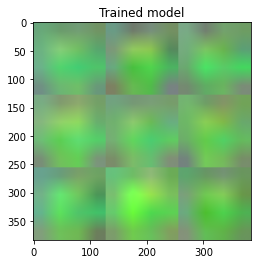

100%|██████████| 781/781 [20:30<00:00,  1.58s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


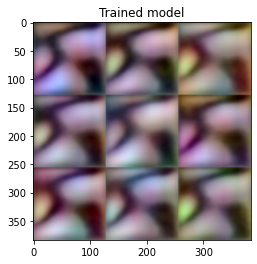

100%|██████████| 781/781 [19:33<00:00,  1.50s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


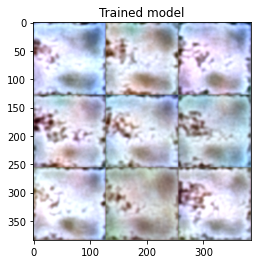

100%|██████████| 781/781 [19:28<00:00,  1.50s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


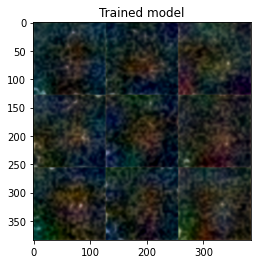

100%|██████████| 781/781 [19:38<00:00,  1.51s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


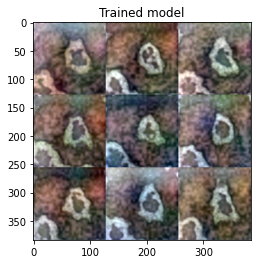

100%|██████████| 781/781 [19:29<00:00,  1.50s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


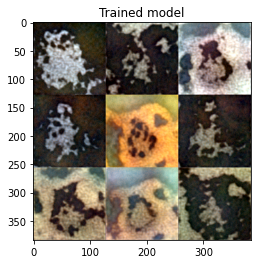

100%|██████████| 781/781 [19:30<00:00,  1.50s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


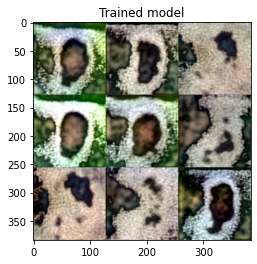

100%|██████████| 781/781 [20:11<00:00,  1.55s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


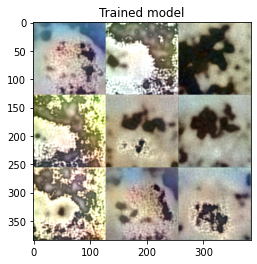

100%|██████████| 781/781 [20:44<00:00,  1.59s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


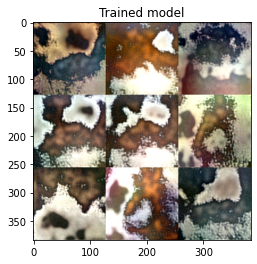

100%|██████████| 781/781 [19:37<00:00,  1.51s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


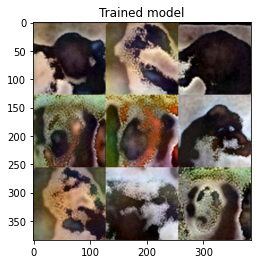

100%|██████████| 781/781 [19:57<00:00,  1.53s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


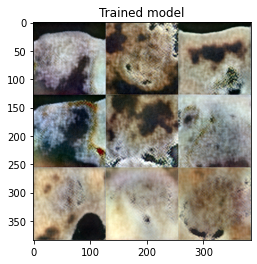

100%|██████████| 781/781 [19:51<00:00,  1.53s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


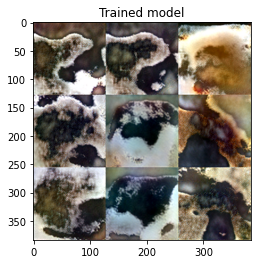

100%|██████████| 781/781 [19:36<00:00,  1.51s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


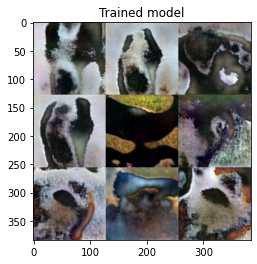

100%|██████████| 781/781 [19:28<00:00,  1.50s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


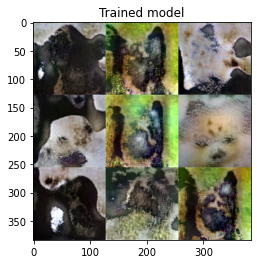

100%|██████████| 781/781 [19:58<00:00,  1.53s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


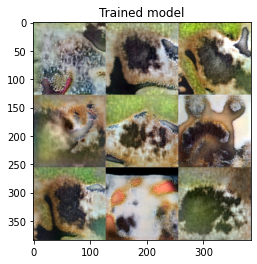

100%|██████████| 781/781 [20:38<00:00,  1.59s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


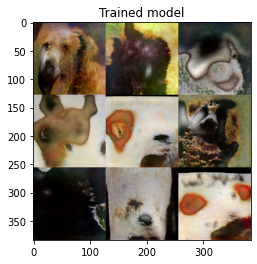

100%|██████████| 781/781 [21:01<00:00,  1.61s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


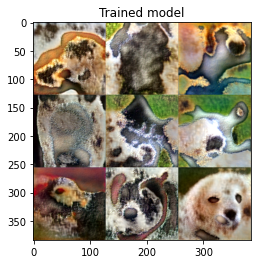

100%|██████████| 781/781 [19:44<00:00,  1.52s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


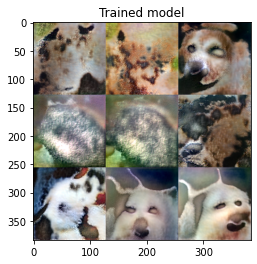

100%|██████████| 781/781 [20:13<00:00,  1.55s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


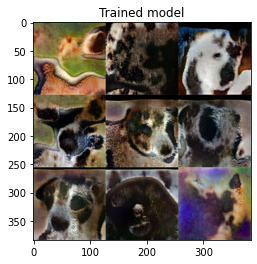

100%|██████████| 781/781 [19:42<00:00,  1.51s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


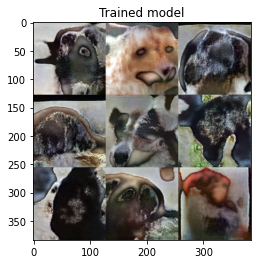

100%|██████████| 781/781 [19:48<00:00,  1.52s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


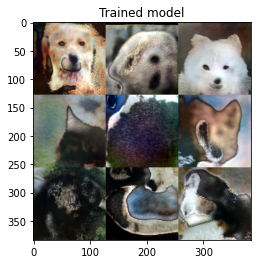

100%|██████████| 781/781 [19:29<00:00,  1.50s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


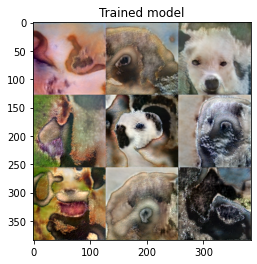

 73%|███████▎  | 567/781 [14:07<05:15,  1.47s/it]

In [ ]:
import json
import os
import tqdm

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

import lib_stylegan

def is_chief(task_type, task_id):
    # If `task_type` is None, this may be operating as single worker, which works
    # effectively as chief.
    return task_type is None or task_type == 'chief' or (
        task_type == 'worker' and task_id == 0)


def noise_image(batch_size):
  random_u = np.random.uniform(size = [batch_size, im_size, im_size, 1])
  return random_u.astype('float32')
def latent_z(n):
  return np.random.normal(size=[n, latent_size]).astype('float32')

def evaluate(M,S,G):
  #Generating 9 test examples
  noise = noise_image(9)
  l_z = latent_z(9)
  #model.M map the lattent vector z to w (Notation from the article).
  l_w = M(l_z)
  style = tf.stack([l_w for i in range(model.n_layers)],axis=1)
  #The seed is what the generator start with, in this case, a learnt constant
  seed = S(style)
  #From the seed, the style w and the noise, model.G generate an image.
  generated = G([seed, style,noise])
  #paking them together
  img = tf.concat([tf.concat([generated[3*i+k] for k in range(3)], axis=1) 
                                  for i in range(3)], axis=0)
  return img.numpy()

tf_config = json.loads(os.environ['TF_CONFIG'])
num_workers = len(tf_config['cluster']['worker'])



im_size = 128
latent_size = 512 
channels = 32 # Should be at least 32 for good results
#Chosing the number of layer this way, means we start with 4x4
nb_layer = int(np.log2(im_size) - 1) 

path="/Data/leo/dogs-face-2015/*jpg"

per_worker_batch_size = 12
global_batch_size = per_worker_batch_size * num_workers


strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()
task_type, task_id = (strategy.cluster_resolver.task_type,
                      strategy.cluster_resolver.task_id)
global_batch_size = per_worker_batch_size * num_workers

with strategy.scope():
    model = lib_stylegan.style_gan.StyleGan(im_size=im_size, 
                                            latent_size=latent_size, 
                                            channels=channels,
                                            nb_layer=nb_layer,
                                            global_batch_size=global_batch_size,
                                            lr = 0.0001)
    model.compile(run_eagerly=True)

dataset = lib_stylegan.dataset.train_dataset(path, 
                                             n_layers=nb_layer, 
                                             im_size=im_size, 
                                             batch_size=per_worker_batch_size,
                                             latent_size=latent_size,
                                             random_seed=int(tf_config["task"]["index"])
                                            )



for args in dataset.take(1):
    per_replica_losses = strategy.run(model.train_step, args=(args,))

print(model.steps)
print(args[-1].numpy())
    
for i in range(1):
    plt.imshow(evaluate(model.M,model.S,model.G))
    plt.title("Trained model")
    plt.show()
    
    #steps_per_epoch = 150000//global_batch_size
    steps_per_epoch = 16

    for args in tqdm.tqdm(dataset.take(steps_per_epoch), total=steps_per_epoch):
        per_replica_losses = strategy.run(model.train_step, args=(args,))

    model.save_weights(f"models/model-{i}.tf")

Small version:
- 10 worker, batch 16: 13 minutes for dataset 
- 26: 5 min
Normal size:
- 1: 8h
- 26: 2h ?

26: 5 min